In [ ]:
# Importing data
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/MyDrive/PDFs/Assessment"
os.chdir(path)
!pip install contractions

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Usual data representation and manipulation libraries
import pandas as pd
import numpy as np
from collections import Counter
# NLTK is very useful for natural language applications
import nltk
# This will be used to tokenize sentences
from nltk.tokenize.toktok import ToktokTokenizer
# We use spacy for extracting useful information from English words
import spacy
nlp = spacy.load('en', parse = False, tag=False, entity=False)
# This dictionary will be used to expand contractions (e.g. we'll -> we will)
from contractions import contractions_dict
import re
# Unicodedata will be used to remove accented characters
import unicodedata
# BeautifulSoup will be used to remove html tags
from bs4 import BeautifulSoup
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Evaluation libraries
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Data integration
df_neg=pd.read_csv('negative.csv')
df_pos=pd.read_csv('positive.csv')
df_final=pd.concat([df_pos,df_neg])
print('shape of df_final is \n', df_final.shape)
print('df_final is \n', df_final.head())

shape of df_final is 
 (50000, 2)
df_final is 
                                               Review  Label
0  Better than Wolff's Kasha. I grew up eating Ka...      1
1  It was such good product. Came in two differen...      1
2  MMMM Yes all chocolate is good.<br />But some ...      1
3  This is, as all of their cereals I've ordered ...      1
4  Whoever Photoshopped the cookie on the front o...      1


In [ ]:
# remove html tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
# remove accented chars
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
# remove special characters
def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text
# expand contractions
def expand_contractions(text, contraction_mapping=contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())), flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(match) else contraction_mapping.get(match.lower())                               
        return first_char+expanded_contraction[1:] if expanded_contraction != None else match
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
# lemmatize text
def lemmatize_text(text):
    text = nlp(text)
    return ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])

In [ ]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
def remove_stopwords(text, is_lower_case=False):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        normalized_corpus.append(doc)
    return normalized_corpus

In [ ]:

if os.path.exists('normalized_food_reviews.csv'):
  print('file exists')
  df_final=pd.read_csv('normalized_food_reviews.csv')
else:
  print('file does not exist')
  df_final['Review']=normalize_corpus(df_final.Review)
  df_final.to_csv('normalized_food_reviews.csv',index=False)


file exists


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


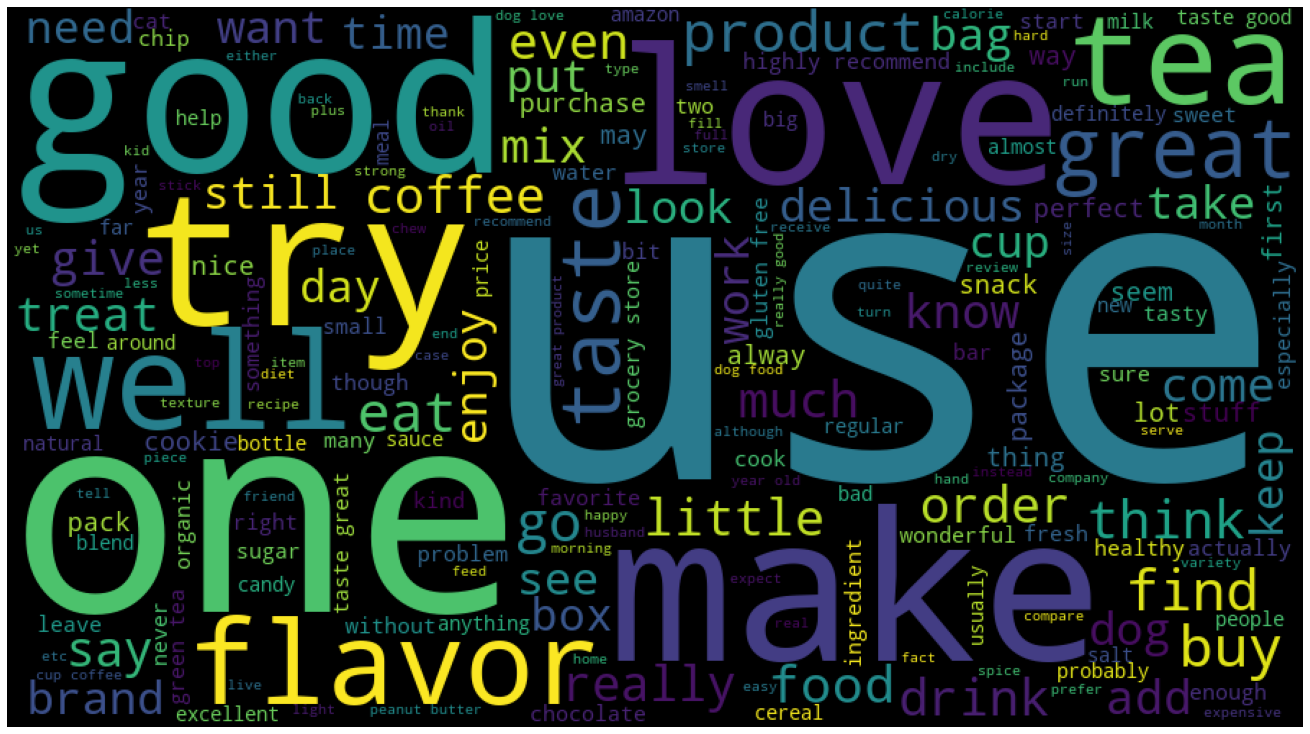

<Figure size 432x288 with 0 Axes>

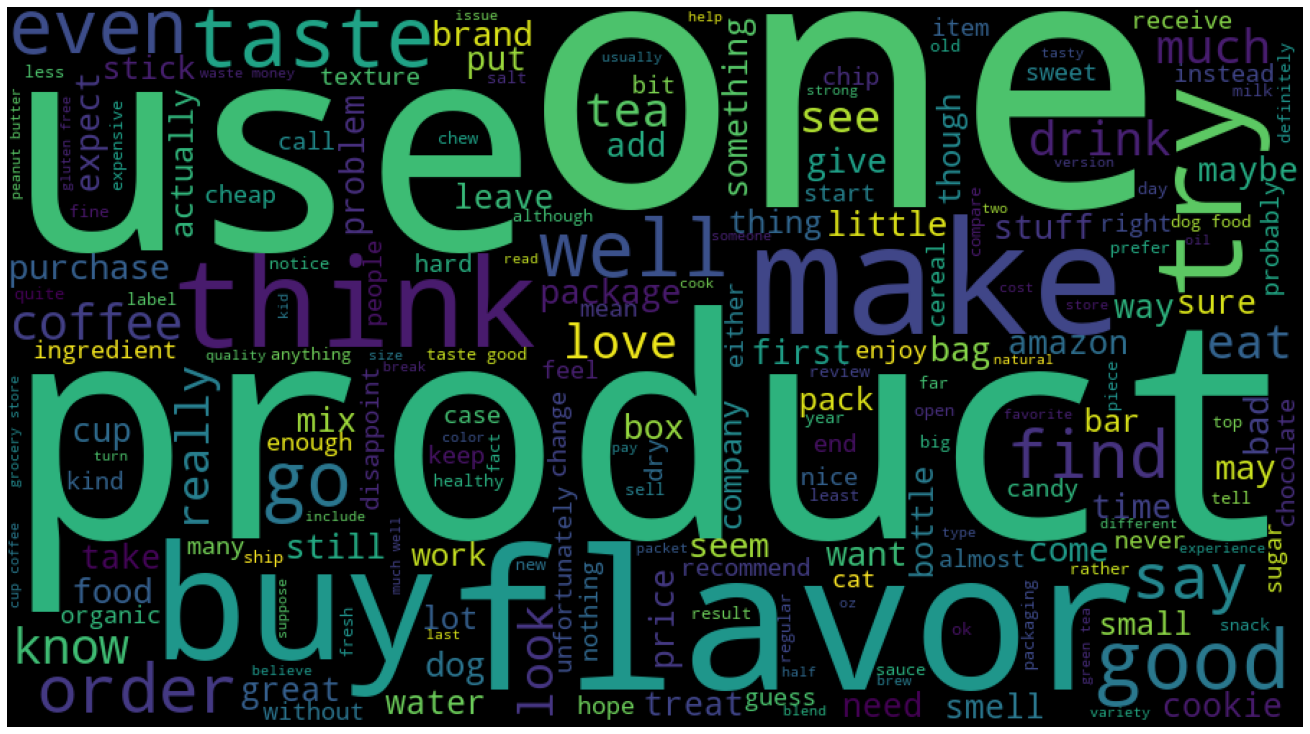

<Figure size 432x288 with 0 Axes>

In [ ]:
# EDA
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
import string
import matplotlib.pyplot as plt
def create_Word_Corpus(temp):
    words_corpus = ''
    for val in temp["Review"]:
        text = str(val).lower()
        tokens = []
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            words_corpus = words_corpus + ' ' + words
    return words_corpus

df_pos['Review']=normalize_corpus(df_pos.Review)
df_neg['Review']=normalize_corpus(df_neg.Review)

# Generate a word cloud image
pos_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(df_pos))
neg_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(df_neg))
# Plot cloud
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='w')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    plt.savefig('wordclouds.png', facecolor='w', bbox_inches='tight')
#Visuallizing popular positive words
plot_Cloud(pos_wordcloud)
#Visuallizing popular negative words
plot_Cloud(neg_wordcloud)

In [ ]:
from sklearn.model_selection import train_test_split
reviews = np.array(df_final['Review'])
sentiments = np.array(df_final['Label'])
train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(reviews,sentiments,test_size=0.3)

In [ ]:
# ML Models
from sklearn.linear_model import SGDClassifier, LogisticRegression
# Libraries for feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(train_reviews)
# transform test reviews into features
cv_test_features = cv.transform(test_reviews)
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
# create LR model
lr = LogisticRegression(penalty='l2', max_iter=1000, C=1)


BOW model:> Train features shape: (35000, 626401)  Test features shape: (15000, 626401)


In [ ]:
# Logistic Regression model on BOW features
lr.fit(cv_train_features,train_sentiments)
y_predicted = lr.predict(cv_test_features)
print("The model accuracy score is: {}".format(accuracy_score(test_sentiments, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_sentiments, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_sentiments, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_sentiments, y_predicted, average="weighted")))
print(classification_report(test_sentiments, y_predicted))
display(pd.DataFrame(confusion_matrix(test_sentiments, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.8776
The model precision score is: 0.877610107047228
The model recall score is: 0.8776
The model F1-score is: 0.8775994211819832
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      7495
           1       0.88      0.88      0.88      7505

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



,Pred. negative,Pred. positive
Act. negative,6596,899
Act. positive,937,6568


In [ ]:
# save model
import pickle
with open('LRBOW.pickle','wb') as f:
     pickle.dump(lr, f)


In [ ]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import  TfidfVectorizer
# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)
# transform test reviews into features
tv_test_features = tv.transform(test_reviews)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)
# create SVM model
svm = SGDClassifier(loss='hinge', max_iter=100)

TFIDF model:> Train features shape: (35000, 626401)  Test features shape: (15000, 626401)


In [ ]:
# Logistic Regression model on TF-IDF features
lr.fit(tv_train_features,train_sentiments)
y_predicted = lr.predict(tv_test_features)
print("The model accuracy score is: {}".format(accuracy_score(test_sentiments, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_sentiments, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_sentiments, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_sentiments, y_predicted, average="weighted")))
print(classification_report(test_sentiments, y_predicted))
display(pd.DataFrame(confusion_matrix(test_sentiments, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.8624
The model precision score is: 0.8625391668120069
The model recall score is: 0.8624
The model F1-score is: 0.8623878559545943
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      7495
           1       0.87      0.85      0.86      7505

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



,Pred. negative,Pred. positive
Act. negative,6536,959
Act. positive,1105,6400


In [ ]:
# SVM model on BOW
svm.fit(cv_train_features,train_sentiments)
y_predicted = svm.predict(cv_test_features)
print("The model accuracy score is: {}".format(accuracy_score(test_sentiments, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_sentiments, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_sentiments, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_sentiments, y_predicted, average="weighted")))
print(classification_report(test_sentiments, y_predicted))
display(pd.DataFrame(confusion_matrix(test_sentiments, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.871
The model precision score is: 0.8712689555234736
The model recall score is: 0.871
The model F1-score is: 0.8709779855906326
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      7495
           1       0.88      0.86      0.87      7505

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



,Pred. negative,Pred. positive
Act. negative,6628,867
Act. positive,1068,6437


In [ ]:
#SVM model on TF-IDF
svm.fit(tv_train_features,train_sentiments)
y_predicted = svm.predict(tv_test_features)
print("The model accuracy score is: {}".format(accuracy_score(test_sentiments, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_sentiments, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_sentiments, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_sentiments, y_predicted, average="weighted")))
print(classification_report(test_sentiments, y_predicted))
display(pd.DataFrame(confusion_matrix(test_sentiments, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.8661333333333333
The model precision score is: 0.8663061599147094
The model recall score is: 0.8661333333333333
The model F1-score is: 0.8661186814608139
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      7495
           1       0.87      0.86      0.86      7505

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



,Pred. negative,Pred. positive
Act. negative,6572,923
Act. positive,1085,6420


In [ ]:
tokenizer = ToktokTokenizer()
# tokenize reviews
tokenized_train = [tokenizer.tokenize(text) for text in train_reviews]
tokenized_test = [tokenizer.tokenize(text) for text in test_reviews]
#Building word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 33588
Sample slice of vocabulary map: {'make': 11, 'barely': 12, 'enough': 13, 'one': 14, 'person': 15, 'premium': 16, 'cost': 17, 'market': 18, 'food': 19, 'not': 20}


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import sequence
# get max length of train corpus and initialize label encoder
le = LabelEncoder()
max_len = np.max([len(review) for review in tokenized_train])
# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len)
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)
# Convert text sentiments into binary encodings
train_y = le.fit_transform(train_sentiments)
test_y = le.transform(test_sentiments)
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

Max length of train review vectors: 985
Train review vectors shape: (35000, 985)  Test review vectors shape: (15000, 985)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 985, 128)          4299264   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 985, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,348,737
Trainable params: 4,348,737
Non-trainable params: 0
_________________________________________________________________
None


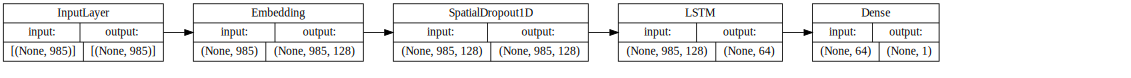

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from IPython.display import SVG
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM

# Creating the LSTM Model
EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
print(model.summary())
SVG(tf.keras.utils.model_to_dot(model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60).create(prog='dot', format='svg'))

In [ ]:
# Training and Evaluating the Model
batch_size = 100
model.fit(train_X, train_y, epochs=5, batch_size=batch_size, shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/5
315/315 [==============================] - 486s 2s/step - loss: 0.5118 - accuracy: 0.7309 - val_loss: 0.3791 - val_accuracy: 0.8394
Epoch 2/5
315/315 [==============================] - 484s 2s/step - loss: 0.2945 - accuracy: 0.8822 - val_loss: 0.3711 - val_accuracy: 0.8460
Epoch 3/5
315/315 [==============================] - 479s 2s/step - loss: 0.2298 - accuracy: 0.9109 - val_loss: 0.4284 - val_accuracy: 0.8471
Epoch 4/5
315/315 [==============================] - 480s 2s/step - loss: 0.1819 - accuracy: 0.9323 - val_loss: 0.4216 - val_accuracy: 0.8437
Epoch 5/5
315/315 [==============================] - 483s 2s/step - loss: 0.1571 - accuracy: 0.9428 - val_loss: 0.4806 - val_accuracy: 0.8389


In [ ]:
pred_test = model.predict_classes(test_X)
y_predicted = le.inverse_transform(pred_test.flatten())
print("The model accuracy score is: {}".format(accuracy_score(test_sentiments, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_sentiments, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_sentiments, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_sentiments, y_predicted, average="weighted")))
print(classification_report(test_sentiments, y_predicted))
display(pd.DataFrame(confusion_matrix(test_sentiments, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


The model accuracy score is: 0.8388666666666666
The model precision score is: 0.8389089808487978
The model recall score is: 0.8388666666666666
The model F1-score is: 0.8388608835384028
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      7495
           1       0.84      0.84      0.84      7505

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



,Pred. negative,Pred. positive
Act. negative,6244,1251
Act. positive,1166,6339


In [ ]:
# read model
pickle_in = open('LRBOW.pickle','rb')
lr = pickle.load(pickle_in)

y_predicted = lr.predict(cv_test_features)
print("The model accuracy score is: {}".format(accuracy_score(test_sentiments, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_sentiments, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_sentiments, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_sentiments, y_predicted, average="weighted")))
print(classification_report(test_sentiments, y_predicted))
display(pd.DataFrame(confusion_matrix(test_sentiments, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

